# 0.0.0. Entender Problema

-- Objetivo do Problema:

    -- 1.0. Previsao do primeiro destino que um novo usuário irá escolher.
    - Porque?
    -- Qual tipo de modelo de negócio do Airbnb?
    
        -- Marketplace ( Conectar pessoas que oferecem acomodacao, com pessoas que estao procurando acomodacao)
        -- Oferta ( pessoas oferecendo acomodacao )
            -- Tamanho do portfólio.
            -- Diversidade/Densidade de Portfólio.
            -- Preco Medio

        -- Demanda ( pessoas procurando acomodacao )
            -- Numero de Usuários
            -- LTV ( Lifetime Value )
            -- CAC ( Client Acquisition Cost )


           Gross Revenue = ( Fee*Numero cliente ) - CAC 
        -- Proposta da Solucao
        
        --- Modelo de Predivao do primeiro destino de um novo usario.
            --- 1.0. Predicoes e salva em tabela do banco de dados. 
            --- 2.0. API 
                        --- Input: usuario e suas caracteristicas
                        --- Output: usuario e suas caracteristicas com a **predicao do destino**

--- 16 ciclos

# 0.0. Imports

In [2]:
import random
import numpy   as np
import pandas  as pd
import seaborn as sns

from sklearn import model_selection as ms
from sklearn import preprocessing   as pp
from sklearn import metrics         as m
from scikitplot import metrics      as mt
from scipy     import stats         as ss

from imblearn   import under_sampling  as us
from imblearn   import over_sampling   as oversamp
from imblearn   import combine         as c

from keras import models as ml
from keras import layers as l

## 0.1. Helper Functions


In [3]:
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

## 0.2. Loading Data


In [4]:
df_raw = pd.read_csv( 'train_users_2.csv', low_memory=True )
df_raw.shape

(213451, 16)

In [5]:
df_sessions = pd.read_csv( 'sessions.csv', low_memory=True )
df_sessions.shape

(10567737, 6)

# 1.0. Data Description

In [6]:
df1 = df_raw.copy() 

## 1.1. Data Dimension


In [7]:
print( 'Number of rows: {}'.format( df1.shape[0] ) )
print( 'Number of columns: {}'.format( df1.shape[1] ) )

Number of rows: 213451
Number of columns: 16


In [8]:
print( 'Number of rows: {}'.format( df_sessions.shape[0] ) )
print( 'Number of columns: {}'.format( df_sessions.shape[1] ) )

Number of rows: 10567737
Number of columns: 6


## 1.2. Data Type


In [9]:
df1.dtypes 

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

In [10]:
df_sessions.dtypes 

user_id           object
action            object
action_type       object
action_detail     object
device_type       object
secs_elapsed     float64
dtype: object

## 1.3. NA Check

In [11]:
#check Na in Percentage
df1.isna().sum() / len( df1 ) 

id                         0.000000
date_account_created       0.000000
timestamp_first_active     0.000000
date_first_booking         0.583473
gender                     0.000000
age                        0.412226
signup_method              0.000000
signup_flow                0.000000
language                   0.000000
affiliate_channel          0.000000
affiliate_provider         0.000000
first_affiliate_tracked    0.028414
signup_app                 0.000000
first_device_type          0.000000
first_browser              0.000000
country_destination        0.000000
dtype: float64

In [12]:
#check Na in Percentage
df_sessions.isna().sum() / len( df_sessions) 

user_id          0.003264
action           0.007535
action_type      0.106570
action_detail    0.106570
device_type      0.000000
secs_elapsed     0.012872
dtype: float64

In [13]:
#remove missing value completly
#df1 = df1.dropna()

# ========== User =================
# date_first_booking
date_first_booking_max = pd.to_datetime( df1['date_first_booking'] ).max().strftime( '%Y-%m-%d' )
df1['date_first_booking'] = df1['date_first_booking'].fillna( date_first_booking_max )

# age
df1 = df1[( df1['age'] > 15 ) & ( df1['age'] < 120 )]
avg_age = df1['age'].mean().astype( int )
df1['age'] = df1['age'].fillna( avg_age )

# first_affiliate_tracked
df1 = df1[~df1['first_affiliate_tracked'].isna()]

# ========== Sessions =================
# user_id - 0.3%
df_sessions = df_sessions[~df_sessions['user_id'].isna()]

# action - 0.7%
df_sessions = df_sessions[~df_sessions['action'].isna()]

# action_type - 11%
df_sessions = df_sessions[~df_sessions['action_type'].isna()]

# action_detail - 11%
df_sessions = df_sessions[~df_sessions['action_detail'].isna()]

# secs_elapsed - 1.2%
df_sessions = df_sessions[~df_sessions['secs_elapsed'].isna()]

In [14]:
df1.isna().sum() / len( df1 ) 

id                         0.0
date_account_created       0.0
timestamp_first_active     0.0
date_first_booking         0.0
gender                     0.0
age                        0.0
signup_method              0.0
signup_flow                0.0
language                   0.0
affiliate_channel          0.0
affiliate_provider         0.0
first_affiliate_tracked    0.0
signup_app                 0.0
first_device_type          0.0
first_browser              0.0
country_destination        0.0
dtype: float64

In [15]:
df_sessions.isna().sum() / len( df_sessions) 

user_id          0.0
action           0.0
action_type      0.0
action_detail    0.0
device_type      0.0
secs_elapsed     0.0
dtype: float64

In [16]:
df1.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
1,820tgsjxq7,2011-05-25,20090523174809,2015-06-29,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US
6,lsw9q7uk0j,2010-01-02,20100102012558,2010-01-05,FEMALE,46.0,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Safari,US


## 1.4. Change Data Type


In [17]:
# date_account_created
df1['date_account_created'] = pd.to_datetime( df1['date_account_created'] )

# timestamp_first_active
df1['timestamp_first_active'] = pd.to_datetime( df1['timestamp_first_active'], format='%Y%m%d%H%M%S' )

# date_first_booking
df1['date_first_booking'] = pd.to_datetime( df1['date_first_booking'] )

# age
df1['age'] = df1['age'].astype( int )

In [18]:
df1.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
1,820tgsjxq7,2011-05-25,2009-05-23 17:48:09,2015-06-29,MALE,38,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,2009-06-09 23:12:47,2010-08-02,FEMALE,56,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,2009-10-31 06:01:29,2012-09-08,FEMALE,42,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,2009-12-08 06:11:05,2010-02-18,-unknown-,41,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US
6,lsw9q7uk0j,2010-01-02,2010-01-02 01:25:58,2010-01-05,FEMALE,46,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Safari,US


## 1.5. Check Balanced Data


In [19]:
df1['country_destination'].value_counts( normalize=True ) 

NDF      0.447275
US       0.391867
other    0.061246
FR       0.029918
IT       0.016423
GB       0.014335
ES       0.013740
CA       0.008676
DE       0.006858
NL       0.004852
AU       0.003531
PT       0.001280
Name: country_destination, dtype: float64

## 1.6. Descriptive Analysis


In [20]:
# Users
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )
time_attributes = df1.select_dtypes( include=['datetime64[ns]'] )

# Sessions
num_attributes_sessions = df_sessions.select_dtypes( include=['int64', 'float64'] )
cat_attributes_sessions = df_sessions.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )
time_attributes_sessions = df_sessions.select_dtypes( include=['datetime64[ns]'] )

## 1.6.1. Numerical - Users


In [21]:
#Estatistas Descritivas de 1. Ordem
# Central Tendency - Mean, Mediana
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersions - Std, Min, Max, Range, Skew, Kurtosis
d1 = pd.DataFrame( num_attributes.apply(np.std)).T
d2 = pd.DataFrame( num_attributes.apply(min)).T
d3 = pd.DataFrame( num_attributes.apply(max)).T
d4 = pd.DataFrame( num_attributes.apply(lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply(lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply(lambda x: x.kurtosis() ) ).T

# Concatenar
ct = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
ct.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
ct

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,age,16.0,115.0,99.0,37.405591,34.0,13.939844,2.089718,6.516468
1,signup_flow,0.0,25.0,25.0,2.519513,0.0,6.604696,2.705871,5.928298


## 1.6.2. Numerical - Sessions


In [22]:
# Central Tendency - Mean, Mediana
ct1 = pd.DataFrame( num_attributes_sessions.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes_sessions.apply( np.median ) ).T

# Dispersions - Std, Min, Max, Range, Skew, Kurtosis
d1 = pd.DataFrame( num_attributes_sessions.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes_sessions.apply( min ) ).T
d3 = pd.DataFrame( num_attributes_sessions.apply( max ) ).T
d4 = pd.DataFrame( num_attributes_sessions.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes_sessions.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes_sessions.apply( lambda x: x.kurtosis() ) ).T

# Concatenar
ct = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
ct.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
ct

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,secs_elapsed,0.0,1799977.0,1799977.0,19961.8251,1369.0,88849.388449,11.137761,154.84312


## 1.6.3. Categorial - Users


In [23]:
cat_attributes.drop( 'id', axis=1 ).describe() 

,gender,signup_method,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
count,122636,122636,122636,122636,122636,122636,122636,122636,122636,122636
unique,4,3,25,8,17,7,4,9,41,12
top,FEMALE,basic,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
freq,56362,66039,118205,79093,78954,64712,108283,57943,41778,54852


## 1.6.3. Categorial - Sessions


In [24]:
cat_attributes_sessions.drop( 'user_id', axis=1 ).describe() 

,action,action_type,action_detail,device_type
count,9213930,9213930,9213930,9213930
unique,347,10,155,14
top,show,view,view_search_results,Mac Desktop
freq,2178382,3545621,1770931,3019523


## 1.6.5.  Correlation Matrix - Sessions



In [25]:
cat_attributes_list = cat_attributes_sessions.drop( 'user_id', axis=1 ).columns.tolist()

corr_dict = {}
for i in range(len(cat_attributes_list)):
    corr_list = []
    for j in range(len(cat_attributes_list)):
        ref = cat_attributes_list[i]
        feat = cat_attributes_list[j]
        
        # correlation
        corr = cramer_v(cat_attributes_sessions[ ref ], cat_attributes_sessions[ feat ])
        
        # append a list
        corr_list.append(corr)
    
    # appende a correlation list for each ref attributs
    corr_dict[ref] = corr_list

<AxesSubplot:>

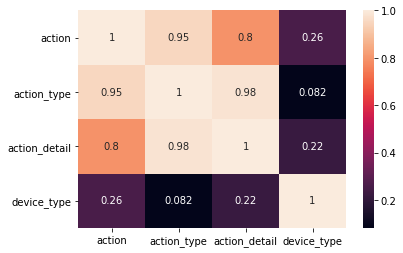

In [26]:
d = pd.DataFrame( corr_dict )
d = d.set_index( d.columns)
sns.heatmap( d, annot=True )

# 2.0. Feature Engineering


In [27]:
df2 = df1.copy() 

In [28]:
df2.dtypes

id                                 object
date_account_created       datetime64[ns]
timestamp_first_active     datetime64[ns]
date_first_booking         datetime64[ns]
gender                             object
age                                 int64
signup_method                      object
signup_flow                         int64
language                           object
affiliate_channel                  object
affiliate_provider                 object
first_affiliate_tracked            object
signup_app                         object
first_device_type                  object
first_browser                      object
country_destination                object
dtype: object

In [29]:
df2.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
1,820tgsjxq7,2011-05-25,2009-05-23 17:48:09,2015-06-29,MALE,38,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,2009-06-09 23:12:47,2010-08-02,FEMALE,56,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,2009-10-31 06:01:29,2012-09-08,FEMALE,42,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,2009-12-08 06:11:05,2010-02-18,-unknown-,41,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US
6,lsw9q7uk0j,2010-01-02,2010-01-02 01:25:58,2010-01-05,FEMALE,46,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Safari,US


## 2.1. Create New Features

In [30]:
# days from first active up to first booking
#convert TimeStanp to DateTime
df2['first_active'] = pd.to_datetime( df2['timestamp_first_active'].dt.strftime( '%Y-%m-%d' ) )
df2['days_from_frist_active_until_booking'] = ( df2['date_first_booking'] - df2['first_active'] ).apply( lambda x: x.days )

# days from first active up to account created
df2['days_from_first_active_until_account_created'] = ( df2['date_account_created'] - df2['first_active'] ).apply( lambda x: x.days )

# days from account createad up to first booking
df2['days_from_account_created_until_first_booking'] = ( df2['date_first_booking'] - df2['date_account_created'] ).apply( lambda x: x.days )

# ================== First Active ==================
# year first active
df2['year_first_active'] = df2['first_active'].dt.year

# month first active
df2['month_fist_active'] = df2['first_active'].dt.month

# day first active
df2['day_first_active'] = df2['first_active'].dt.day

# day of week first active
df2['day_of_week_first_active'] = df2['first_active'].dt.dayofweek

# week of year first active
df2['week_of_year_first_active'] = df2['first_active'].dt.weekofyear

# ================== First Booking ==================
# year first booking
df2['year_first_booking'] = df2['date_first_booking'].dt.year

# month first booking
df2['month_first_booking'] = df2['date_first_booking'].dt.month

# day first booking
df2['day_first_booking'] = df2['date_first_booking'].dt.day

# day of week first booking
df2['day_of_week_first_booking'] = df2['date_first_booking'].dt.dayofweek

# week of year first booking
df2['week_of_year_first_booking'] = df2['date_first_booking'].dt.weekofyear

# ================== First Account Created =================
# year first booking
df2['year_account_created'] = df2['date_account_created'].dt.year

# month  account_created
df2['month_account_created'] = df2['date_account_created'].dt.month

# day  account_created
df2['day_account_created'] = df2['date_account_created'].dt.day

# day of week  account_created
df2['day_of_week_account_created'] = df2['date_account_created'].dt.dayofweek

# week of year  account_created
df2['week_of_year_account_created'] = df2['date_account_created'].dt.weekofyear

<ipython-input-30-f8774fb10a55>:26: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df2['week_of_year_first_active'] = df2['first_active'].dt.weekofyear
<ipython-input-30-f8774fb10a55>:42: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df2['week_of_year_first_booking'] = df2['date_first_booking'].dt.weekofyear
<ipython-input-30-f8774fb10a55>:58: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df2['week_of_year_account_created'] = df2['date_account_created'].dt.weekofyear


# 3.0. Data Filtering 

In [31]:
df3 = df2.copy()
df3.shape

(122636, 35)

## 3.1. Filtering Rows


In [32]:
# Filtering rows:
# age - greater than 15 and lower than 120 - There are few people over 12O year old   
df3 = df3[( df3['age'] > 15 ) & ( df2['age'] < 120 )]

# secs_elapsed - there is no possible 0 secs elapsed on website
#df3 = df3[df3['secs_elapsed'] > 0]

## 3.2. Columns Selection

In [33]:
cols = ['date_account_created', 'date_account_created', 'date_first_booking', 'timestamp_first_active', 'first_active'] # original datetime
df3 = df3.drop( cols, axis=1 )

# 4.0 Balanced Dataset


In [34]:
df4 = df3.copy()
df4.shape

(122636, 31)

In [35]:
# Encoder Categorical Variables
ohe = pp.OneHotEncoder()

# Numerical
col_num = df4.select_dtypes( include=['int64', 'float64'] ).columns.tolist()

# Categorical
col_cat = df4.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] ).drop( ['id', 'country_destination'], axis=1 ).columns.tolist()

# encoding
df4_dummy = pd.DataFrame( ohe.fit_transform( df4[ col_cat] ).toarray(), index=df4.index )

# join numerical and categorical
df42 = pd.concat( [df4[col_num], df4_dummy], axis=1 )
df42.shape

(122636, 138)

## 4.1 Random Undersampling

In [36]:
# ratio_balanced
ratio_balanced = {'NDF': 10000 }
# define sampler
undersampling = us.RandomUnderSampler(sampling_strategy=ratio_balanced, random_state=32)

# apply sampler
X_under, y_under = undersampling.fit_resample( df42, df4['country_destination'])

In [37]:
df4['country_destination'].value_counts() 

NDF      54852
US       48057
other     7511
FR        3669
IT        2014
GB        1758
ES        1685
CA        1064
DE         841
NL         595
AU         433
PT         157
Name: country_destination, dtype: int64

In [38]:
y_under.value_counts() 

US       48057
NDF      10000
other     7511
FR        3669
IT        2014
GB        1758
ES        1685
CA        1064
DE         841
NL         595
AU         433
PT         157
Name: country_destination, dtype: int64

## 4.2 Random Oversampling

In [39]:
# ratio_balanced
#ratio_balanced = {'NDF': 10000 }

# define sampler
oversampling = oversamp.RandomOverSampler( sampling_strategy='all', random_state=32 )

# apply sampler
X_over, y_over = oversampling.fit_resample( df42, df4['country_destination'] )

In [40]:
df4['country_destination'].value_counts() 

NDF      54852
US       48057
other     7511
FR        3669
IT        2014
GB        1758
ES        1685
CA        1064
DE         841
NL         595
AU         433
PT         157
Name: country_destination, dtype: int64

In [41]:
y_over.value_counts() 

PT       54852
FR       54852
AU       54852
IT       54852
NDF      54852
ES       54852
DE       54852
US       54852
GB       54852
CA       54852
other    54852
NL       54852
Name: country_destination, dtype: int64

## 4.3. SMOTE + TOMEKLINK

In [42]:
ratio_balanced =  {'NDF': 54852,
                   'US':  48057,
                   'other': 6*7511,
                   'FR': 12*3669,
                   'IT': 20*2014,
                   'GB': 30*1758,
                   'ES': 30*1685,
                   'CA': 40*1064,
                   'DE': 45*841,
                   'NL': 80*595,
                   'AU': 85*433,
                   'PT': 300*157}

In [43]:
# define sampler
smt = c.SMOTETomek( sampling_strategy=ratio_balanced, random_state=32, n_jobs=-1 )

# apply sampler
X_smt, y_smt = smt.fit_resample( df42, df4['country_destination'] )

KeyboardInterrupt: 

In [ ]:
df4['country_destination'].value_counts() 

In [ ]:
# numerical data
df43 = X_smt[ col_num ]

# categorical data
df44 = X_smt.drop( col_num, axis=1 )
df45 = pd.DataFrame( ohe.inverse_transform( df44 ), columns=col_cat, index=df44.index )

# join numerical categorical
df46 = pd.concat( [df43, df45], axis=1 )
df46['country_destination'] = y_smt

# 5.0. Data Preparation


In [ ]:
df5 = df4.copy()
df5.shape

In [ ]:
 # dummy variable
df5_dummy = pd.get_dummies( df3.drop( ['id', 'country_destination'], axis=1 ) )

# join id and country destination
df5 = pd.concat( [df3[['id', 'country_destination']], df3_dummy], axis=1 )

In [ ]:
df4.shape 

# 6.0. Feature Selection


In [ ]:
cols_drop = ['date_account_created', 'timestamp_first_active', 'date_first_booking'] # original dates
df6 = df5.drop( cols_drop, axis=1 )

In [ ]:
X = df6.drop( 'country_destination', axis=1 )
y = df6['country_destination'].copy()

In [ ]:
# Split dataset into training and test
X_train, X_test, y_train, y_test = ms.train_test_split( X, y, test_size=0.2, random_state=22 )

# 6.0. Machine Learning Model

In [ ]:
x_train = X_train.drop( 'id', axis=1 )
x_test = X_test.drop( 'id', axis=1 )

## 6.1. Baseline Model


In [ ]:
country_destination_list = df1['country_destination'].drop_duplicates().sort_values().tolist()
k_num = y_test.shape[0]
country_destination_weights = df1['country_destination'].value_counts( normalize=True ).sort_index().tolist()

yhat_random = random.choices( population=country_destination_list,  
                              weights=country_destination_weights,
                              k=k_num )

## 5.1. Baseline Model Performance


In [ ]:
 # Accuracy
acc_random = m.accuracy_score( y_test, yhat_random )
print( 'Accuracy: {}'.format( acc_random ) )

# Balanced Accuray
balanced_acc_random = m.balanced_accuracy_score( y_test, yhat_random )
print( 'Balanced Accuracy:{}'.format( balanced_acc_random ) )

# Kappa Metrics
kappa_random = m.cohen_kappa_score( y_test, yhat_random )
print( 'Kappa Score: {}'.format( kappa_random ) )

# Classification report
print( m.classification_report( y_test, yhat_random ) )

# Confusion Matrix
mt.plot_confusion_matrix( y_test, yhat_random, normalize=False, figsize=(12,12))

## Neural Network - MLP


In [ ]:
ohe = pp.OneHotEncoder()
y_train_nn = ohe.fit_transform( y_train.values.reshape( -1, 1 ) ).toarray()

In [ ]:
print( 'Number of Rows: {}'.format( x_train.shape[0] ) )
print( 'Number of Features: {}'.format( x_train.shape[1] ) )
print( 'Number of Classes: {}'.format( y_train.nunique() ) )

In [ ]:
# model definition
model = ml.Sequential()
model.add( l.Dense( 256, input_dim=x_train.shape[1], activation='relu' ) )
model.add( l.Dense( 12, activation='softmax') )

# model compile
model.compile( loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'] )

# train model
model.fit( x_train, y_train_nn, epochs=100 )

##  NN Performance

In [ ]:
# prediction
pred_nn = model.predict( x_test )

# invert prediction
yhat_nn = ohe.inverse_transform( pred_nn )

# prediction prepare
y_test_nn = y_test.to_numpy()
yhat_nn = yhat_nn.reshape( 1, -1 )[0]